In [1]:
from __future__ import print_function, division

import os
import operator
import functools
import time
import glob
import tables as tb
import pandas as pd
print("Running on ", time.asctime())

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import invisible_cities.database.load_db as DB
import invisible_cities.core.system_of_units_c as SystemOfUnits
import invisible_cities.reco.pmaps_functions as pmapf
import invisible_cities.core.fit_functions as fitf

DataPMT = DB.DataPMT()
DataSiPM = DB.DataSiPM()
units = SystemOfUnits.SystemOfUnits()
pi = np.pi

Running on  Sun May  7 17:29:15 2017


In [2]:
plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

outputfolder = "plots/Na_Coincidence"
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

In [3]:
def width(times, to_mus=False):
    """
    Compute peak width.
    """
    w = (np.max(times) - np.min(times)) if np.any(times) else 0.
    return w * units.ns/units.mus if to_mus else w


def timefunc(f):
    """
    Decorator for function timing.
    """
    def time_f(*args, **kwargs):
        t0 = time.time()
        output = f(*args, **kwargs)
        print("Time spent in {}: {} s".format(f.__name__,
                                              time.time() - t0))
        return output
    return time_f


def integrate_charge(d):
    """
    Integrate charge from a SiPM dictionary.
    """
    newd = dict((key, np.sum(value)) for key, value in d.items())
    return map(np.array, list(zip(*newd.items())))


def flat(nested_list):
    while hasattr(nested_list[0], "__iter__"):
        nested_list = [item for inner_list in nested_list for item in inner_list]
    return np.array(nested_list)


def labels(xlabel, ylabel):
    """
    Set x and y labels.
    """
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


def hist(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist(*args, **kwargs)

    
def hist2d(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist2d(*args, **kwargs)

    
def pdf(data, *args, **kwargs):
    """
    Create a normalized histogram with appropiate range.
    """
    data = np.array(data)
    h = hist(data, *args, **kwargs, weights=np.ones_like(data)/len(data))
    plt.yscale("log")
    plt.ylim(1e-4, 1.)
    return h
    
def scatter(*args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    return plt.scatter(*args, **kwargs)


def save_to_folder(outputfolder, name):
    """
    Set title and save plot in folder.
    """
    plt.title(name)
    plt.savefig("{}/{}.png".format(outputfolder, name), dpi=100)



def get_centers(xbins):
    # xbins should be shifted, as it contains the lower bounds
    # and we want bin centers
    return xbins[:-1] + np.diff(xbins) * 0.5


def profile_and_scatter(x, y, z, nbin, *args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    x, y, z, ze = fitf.profileXY(x, y, z, *nbin, *args, **kwargs)
    x_ = np.repeat(x, x.size)
    y_ = np.tile  (y, y.size)
    z_ = z.flatten()
    return (x, y, z, ze), plt.scatter(x_, y_, c=z_, marker="s"), plt.colorbar()

two_gauss = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:-1])+args[-1]
one_gauss = lambda x, *args: fitf.gauss(x, *args[:3]) +args[-1]
save = functools.partial(save_to_folder, outputfolder)

In [4]:
# Comment out this line if your data is in $IC_DATA
os.environ["IC_DATA"] = "/home/brais/Documents/Next/Na/data/"

pattern = "$IC_DATA/3901/dst_*.h5"
ifiles  = glob.glob(os.path.expandvars(pattern))
print("# files:", ifiles)

# files: ['/home/brais/Documents/Next/Na/data//3901/dst_3901.root.h5']


In [5]:
def load_dst(filename, group, node):
    with tb.open_file(filename) as h5in:
        table = getattr(getattr(h5in.root, group), node).read()
        return pd.DataFrame.from_records(table)

In [6]:
data_read = load_dst(ifiles[0], "DST", "Events")

In [7]:
from copy import deepcopy
from functools import reduce

def Filter(data, verbosity=False):
    filtered_XR = deepcopy(data)
    filtered_noXR = deepcopy(data)
    
    min_S1w = 250.
    max_S1w = 400.
    min_S1h = 10.
    max_S1h = 100.
    
    min_S2e = 2500.
    max_S2e = 10000.
    
    if verbosity: print('Inicial: ',len(filtered_XR), len(filtered_noXR))

    filtered_XR = filtered_XR[filtered_XR.nS2>1]
    if verbosity: print('nS2 > 1: ', len(filtered_XR))
    
    filtered_XR = filtered_XR[filtered_XR.S2e>min_S2e]
    filtered_XR = filtered_XR[filtered_XR.S2e<max_S2e]
    
    
    if verbosity: print('S2 XR Energy: ', len(filtered_XR))
    
    filtered_XR = filtered_XR[filtered_XR.Nsipm>0]
    
    if verbosity: print('Nsimp > 0: ', len(filtered_XR))
    

    
    
    #filtered_noXR = filtered_noXR[filtered_noXR.S2e<min_S2e]
    filtered_noXR = filtered_noXR[filtered_noXR.S2e>max_S2e]
    
    if verbosity: print('no XR: ', len(filtered_noXR))
    
    return filtered_XR, filtered_noXR


In [8]:
filt_XR, filt_noXR = Filter(data_read,1)
full = data_read[:]

def get_zcorr(zfun, coef):
    def zcorr(z):
        return zfun(coef)/zfun(z)
    return zcorr

Inicial:  19530 19530
nS2 > 1:  11075
S2 XR Energy:  3206
Nsimp > 0:  3206
no XR:  16161


FitFunction(fn=<function fit.<locals>.<lambda> at 0x7efeeb777510>, values=array([ 8130.96217098,  -762.31254999]), errors=array([ 151.24290571,   66.10135347]), chi2=0.67072693692355678)


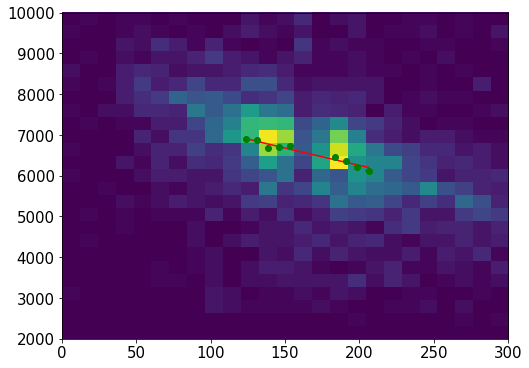

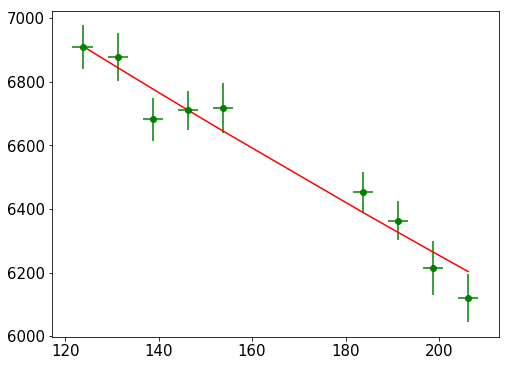

In [9]:
rcut = 305.0
data_ = filt_XR
data_ = data_[data_.R<rcut]

xbin, ybin, z, axis = hist2d(data_.Z, data_.S2e, [25,25], [[0,300], [2000,10000]])
#

x, y, ey             = fitf.profileX(data_.Z, data_.S2e, 12, xrange=[120,210], yrange=[4000,8500])
#plt.errorbar(x, y, yerr=ey, fmt='o', color='g')#, profOpt)

sel                 = fitf.in_range(x, 155, 180)
x, y, ey            = x[~sel], y[~sel], ey[~sel]
plt.errorbar(x, y, yerr=ey, xerr=(x[1]-x[0])/12**0.5, fmt='o', color='g')#, profOpt)
f                   = fitf.fit(fitf.expo, x, y, (1e4, -250), sigma=ey)

plt.plot(x, f.fn(x), fitOpt)

print(f)

#labels("Drift time ($\mu$s)", "Event energy (pes)")

f_g      = lambda z: fitf.expo(z,f.values[0], -730)

zcorr  = get_zcorr(f.fn, np.min(x))
zcorr_g  = get_zcorr(f_g, np.min(x))
  
plt.show()    
plt.errorbar(x, y, yerr=ey, xerr=(x[1]-x[0])/12**0.5, fmt='o', color='g')#, profOpt)
plt.plot(x, f.fn(x), fitOpt)


FitFunction(fn=<function fit.<locals>.<lambda> at 0x7efee8ae0620>, values=array([ 7197.54125863, -3996.30588575]), errors=array([  112.93747938,  1488.06555197]), chi2=0.44008179189213664)


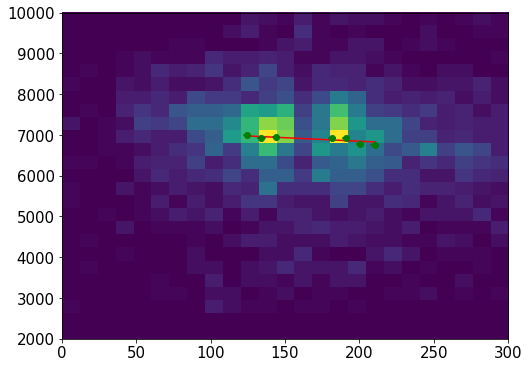

In [10]:
rcut = 180.0
data_ = filt_XR
E = data_.S2e * zcorr(data_.Z)

xbin, ybin, z, axis = hist2d(data_.Z, E, [25,25], [[0,300], [2000,10000]])
#

x, y, ey             = fitf.profileX(data_.Z, E, 10, xrange=[120,215], yrange=[4000,9000])
#plt.errorbar(x, y, yerr=ey, fmt='o', color='g')#, profOpt)

sel                 = fitf.in_range(x, 150, 180)
x, y, ey            = x[~sel], y[~sel], ey[~sel]
plt.errorbar(x, y, yerr=ey, xerr=(x[1]-x[0])/12**0.5, fmt='o', color='g')#, profOpt)
f                   = fitf.fit(fitf.expo, x, y, (1e4, -250), sigma=ey)

plt.plot(x, f.fn(x), fitOpt)

print(f)



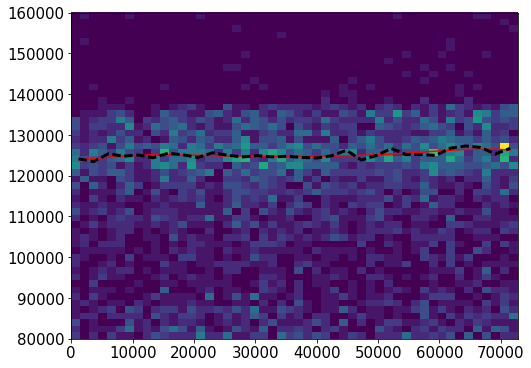

In [11]:
def get_tcorr(tfun, tmin):
    def tcorr(t):
        return tfun(tmin)/tfun(t)
    return tcorr



data_        = full[(full.nS2==1)&(full.R<180)]
E            = data_.S2e * zcorr(data_.Z) #* xycorr(data_.X.values, data_.Y.values)
time         = data_.time.values
time        -= np.min(time)

hist2d(time, E,[50,50],[[min(time),max(time)],[0.8e5,1.6e5]]);

x, y, _      = fitf.profileX(time,E, 30, xrange = (min(time),max(time)), yrange=[1.1e5,1.6e5])
f            = fitf.fit(fitf.polynom, x, y, (6000,-200,1,2,3,1,2,3,5))

plt.plot(x, f.fn(x), fitOpt)
#print(f.values,f.errors)

plt.plot(x, y, profOpt, linewidth=3)
#labels("time (s)", "Energy (pes)")

tcorr = get_tcorr(f.fn, np.min(x))

[  1.42263690e+05   7.13919930e+03   4.66566522e+02   1.78812907e+04
   8.48039169e+03   2.85408230e+02   1.48025669e-15] 
 [  6.18303473e+04   2.33785833e+01   8.22700950e+01   3.53376551e+04
   1.43971901e+02   2.54862712e+02   3.28908675e+01]
res 0.153905796973 0.0170029652113


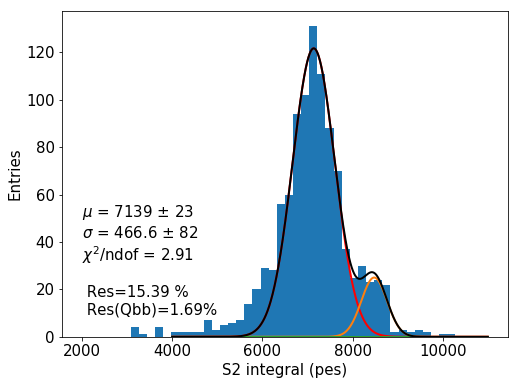

In [12]:
data_ = filt_XR
selZ  = fitf.in_range(data_.Z, 0, 150)
selR  = fitf.in_range(data_.R, 0, 180)
data_ = data_[selZ&selR]

time         = data_.time.values
time        -= np.min(time)

Ez_ = data_.S2e * zcorr(data_.Z) * tcorr(time)


entries, xbins, _ = hist(Ez_, 50, range=(2e3, 11e3))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 6.5e3, 9e3)


f = fitf.fit(two_gauss, xbins[selbins], entries[selbins],( 10e4, 7000, 500, 9e4, 8050, 500, 0),
                                                  bounds=([ 8e4, 6000, 100, 1e3, 7000, 10, 0],
                                                          [10e6, 8000, 1000,15e5, 10000, 2000, 100] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values,"\n",f.errors)
print('res',res,(30/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("$\mu$ $\sigma$".split(),
                                            f.values[1:],
                                            f.errors[1:])] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (29.6/2458)**0.5*res*100)

xrange = np.linspace(4e3, 11e3,1000)

plt.text(min(xbins)-100, 10, text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=2)
plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]), linewidth=2)
plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=2)
plt.plot(xrange, f.fn(xrange), "k-", linewidth=2)


labels("S2 integral (pes)", "Entries")
#save("RX XYZ Corr (Z<150 R<180)")


In [34]:
def get_xycorr(xs, ys, es, eref=None):
    if eref is None:
        eref = es[es.shape[0]//2, es.shape[1]//2]
    xs   = xs.reshape(xs.size, 1)
    ys   = ys.reshape(ys.size, 1)
#    print(eref)
    def xycorr(x, y):
        x_closest = np.apply_along_axis(np.argmin, 0, abs(x-xs))
        y_closest = np.apply_along_axis(np.argmin, 0, abs(y-ys))
        e = es[x_closest, y_closest]
        e[e<1e3] = eref
        return eref/ e
    return xycorr

xs = np.loadtxt('xycorr_xs_3614.dat')
ys = np.loadtxt('xycorr_ys_3614.dat')

es3614  = np.loadtxt('xycorr_es_3614.dat')

es37xx  = np.loadtxt('xycorr_es_S1.dat')
#es3614 *= es37xx[12,12]/ es3614[12,12] 

es3904  = np.loadtxt('xycorr_es_3904.dat')

xycorr_c3 = get_xycorr(xs, ys,es3614+es37xx+es3904)

/home/brais/Documents/Next/IC/IC-1/invisible_cities/core/fit_functions.py:123: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum(np.ma.masked_invalid((fitx - y)**2/y))


[  5.52004785e+04   7.11125896e+03   2.07340885e+02   1.13707403e+04
   8.04275411e+03   2.12338226e+02   2.00571309e+00] 
 [  1.01707799e+03   3.86112116e+00   4.07796086e+00   1.03266739e+03
   1.94189363e+01   2.05513372e+01   4.81690799e-01]
res 0.0686640421075 0.00758575922537


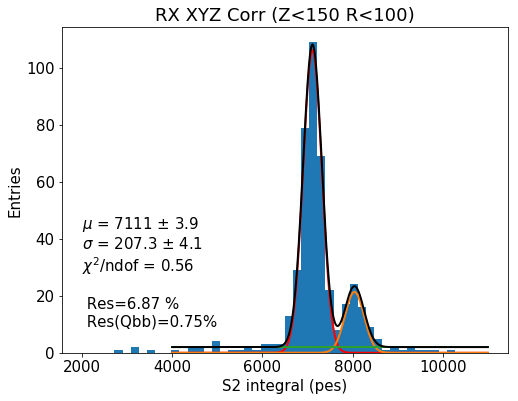

In [40]:
data_ = filt_XR
selZ  = fitf.in_range(data_.Z, 0, 150)
selR  = fitf.in_range(data_.R, 0, 100)
data_ = data_[selZ&selR]

time         = data_.time.values
time        -= np.min(time)

Ez_ = data_.S2e * zcorr(data_.Z) * tcorr(time) * xycorr_c(data_.X.values, data_.Y.values)


entries, xbins, _ = hist(Ez_, 50, range=(2e3, 11e3))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 4.0e3, 9e3)


f = fitf.fit(two_gauss, xbins[selbins], entries[selbins],( 10e4, 7000, 500, 9e4, 8050, 300, 0),
                                                  bounds=([ 2e3, 6000, 10, 1e3, 7500, 10, 0],
                                                          [10e6, 8500, 1000,15e5, 10000, 500, 100] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values,"\n",f.errors)
print('res',res,(30/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("$\mu$ $\sigma$".split(),
                                            f.values[1:],
                                            f.errors[1:])] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (29.6/2458)**0.5*res*100)

xrange = np.linspace(4e3, 11e3,1000)

plt.text(min(xbins)-100, 10, text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=2)
plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]), linewidth=2)
plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=2)
plt.plot(xrange, f.fn(xrange), "k-", linewidth=2)


labels("S2 integral (pes)", "Entries")
plt.title("RX XYZ Corr (Z<150 R<100)")


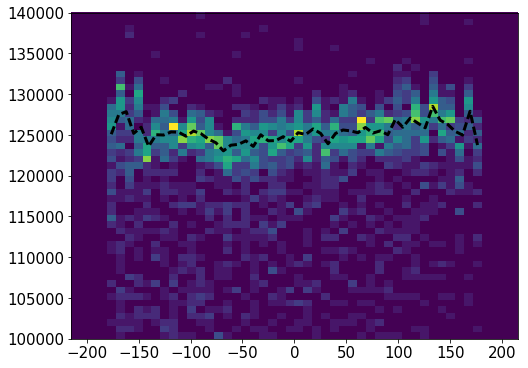

In [16]:
data_ = full[full.nS2 ==1]
selR  = fitf.in_range(data_.R, 0, 180)
data_ = data_[selR]


time         = data_.time.values
time        -= np.min(time)

E = data_.S2e * zcorr_g(data_.Z) *tcorr(time) * xycorr_c(data_.X.values,data_.Y.values)
hist2d(data_.X,E,[50,50],[[-215,215],[1.0e5, 1.4e5]]);
x, y, _ = fitf.profileX(data_.X,E, 50, xrange=[-180, 180], yrange=[1.2e5,1.4e5])
plt.plot(x, y, profOpt, linewidth=3)

def get_xcorr(T, E):
    eref = np.max(E)
    def phicorr(t):
        dt = np.abs(t[:, np.newaxis]-T)
        return eref / E[np.apply_along_axis(np.argmin, 1, dt)]
    return phicorr
xcorr_PP = get_xcorr(x, y)

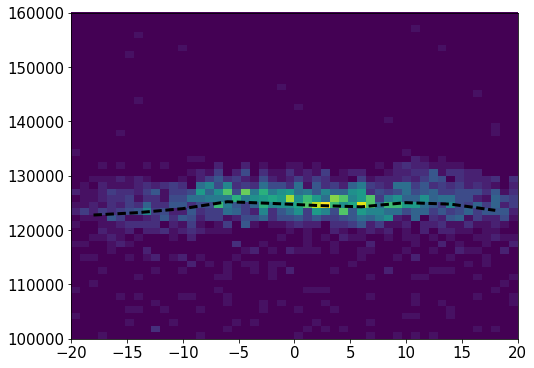

In [17]:
data_ = full[full.nS2 ==1]
selR  = fitf.in_range(data_.R, 0, 180)
data_ = data_[selR]


time         = data_.time.values
time        -= np.min(time)

E = data_.S2e * zcorr_g(data_.Z) *tcorr(time)* xycorr_c(data_.X.values,data_.Y.values)
hist2d(data_.Y,E,[50,50],[[-20,20],[1.0e5, 1.6e5]]);
x, y, _ = fitf.profileX(data_.Y,E, 10, xrange=[-20, 20], yrange=[1.0e5,1.6e5])
plt.plot(x, y, profOpt, linewidth=3)

def get_xcorr(T, E):
    eref = np.max(E)
    def phicorr(t):
        dt = np.abs(t[:, np.newaxis]-T)
        return eref / E[np.apply_along_axis(np.argmin, 1, dt)]
    return phicorr
ycorr_PP = get_xcorr(x, y)

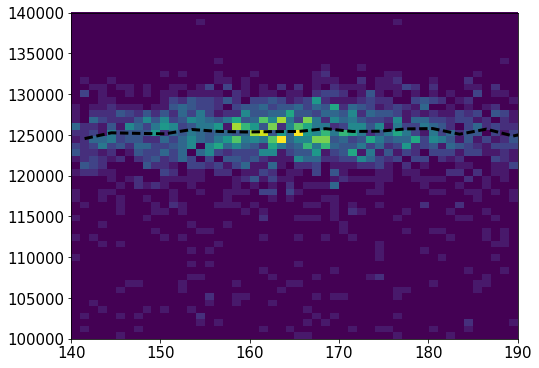

In [18]:
data_ = full[full.nS2 ==1]
selR  = fitf.in_range(data_.R,   0, 180)
selZ  = fitf.in_range(data_.Z, 140, 200)
data_ = data_[selR&selZ]


time         = data_.time.values
time        -= np.min(time)

E = data_.S2e * zcorr_g(data_.Z) *tcorr(time) * xycorr_c(data_.X.values,data_.Y.values)

hist2d(data_.Z,E,[50,50],[[140,190],[1.0e5, 1.4e5]]);
x, y, _ = fitf.profileX(data_.Z,E, 20, xrange=[140, 200], yrange=[1.2e5,1.4e5])
plt.plot(x, y, profOpt, linewidth=3)

def get_xcorr(T, E):
    eref = np.max(E)
    def phicorr(t):
        dt = np.abs(t[:, np.newaxis]-T)
        return eref / E[np.apply_along_axis(np.argmin, 1, dt)]
    return phicorr
zcorr_PP = get_xcorr(x, y)

/home/brais/Documents/Next/IC/IC-1/invisible_cities/core/fit_functions.py:123: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum(np.ma.masked_invalid((fitx - y)**2/y))


[  4.31486241e+06   1.24876191e+05   2.68906933e+03   7.90275262e+00]
res 0.0507122953632 0.0231223930329


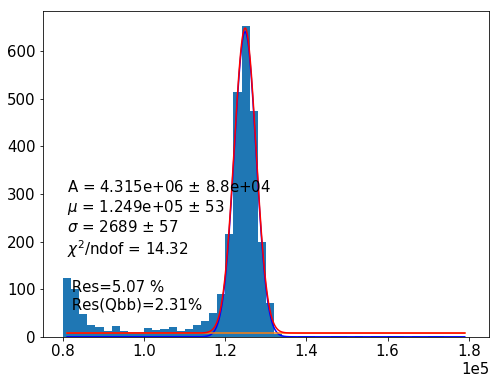

In [19]:
data_ = full[full.nS2 ==1]
selR  = fitf.in_range(data_.R,   0, 180)
selZ  = fitf.in_range(data_.Z, 140, 200)
data_ = data_[selR&selZ]


time         = data_.time.values
time        -= np.min(time)

E = data_.S2e * zcorr(data_.Z) *tcorr(time)* xycorr_c(data_.X.values,data_.Y.values)

entries, xbins, _ = hist(E, 50, range=(0.80e5, 1.8e5))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 1.1e5, 1.6e5)


f = fitf.fit(one_gauss, xbins[selbins], entries[selbins],( 9e4 , 1.2e5, 5000, 10),
                                                 bounds=([ 1e4 , 1.0e5, 1000,  0],
                                                         [ 10e7, 1.6e5, 10000, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(511/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (511/2458)**0.5*res*100)


xrange = np.linspace(np.min(xbins), np.max(xbins),1000)
plt.text(np.min(xbins), np.mean(entries), text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), fitOpt)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

/home/brais/Documents/Next/IC/IC-1/invisible_cities/core/fit_functions.py:123: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum(np.ma.masked_invalid((fitx - y)**2/y))


[  4.21724542e+06   1.30539148e+05   2.37969916e+03   1.12550914e+01]
res 0.0429311175872 0.0195745463123


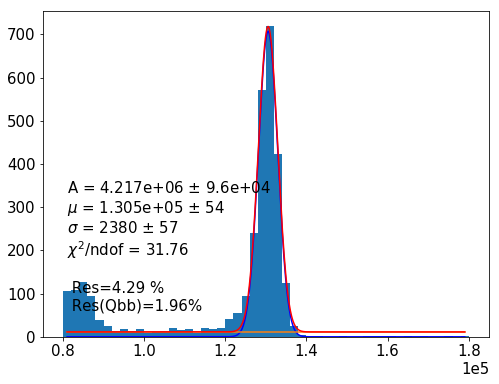

In [21]:
data_ = full[full.nS2 ==1]
selR  = fitf.in_range(data_.R,   0, 180)
selZ  = fitf.in_range(data_.Z, 140, 200)
data_ = data_[selR&selZ]


time         = data_.time.values
time        -= np.min(time)

E  = data_.S2e * zcorr(data_.Z) *tcorr(time)* xycorr_c(data_.X.values,data_.Y.values)
E *= xcorr_PP(data_.X.values) * ycorr_PP(data_.X.values) * zcorr_PP(data_.Z.values)

entries, xbins, _ = hist(E, 50, range=(0.80e5, 1.8e5))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 1.1e5, 1.6e5)


f = fitf.fit(one_gauss, xbins[selbins], entries[selbins],( 9e4 , 1.2e5, 5000, 10),
                                                 bounds=([ 1e4 , 1.0e5, 1000,  0],
                                                         [ 10e7, 1.6e5, 10000, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(511/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (511/2458)**0.5*res*100)


xrange = np.linspace(np.min(xbins), np.max(xbins),1000)
plt.text(np.min(xbins), np.mean(entries), text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), fitOpt)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

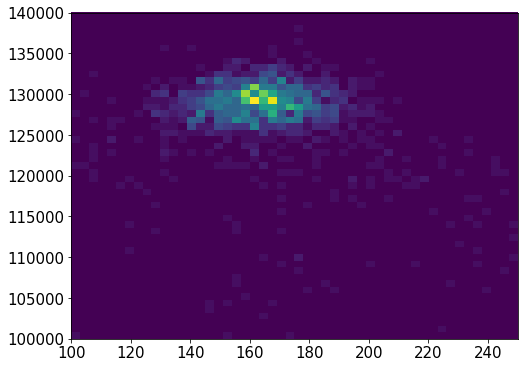

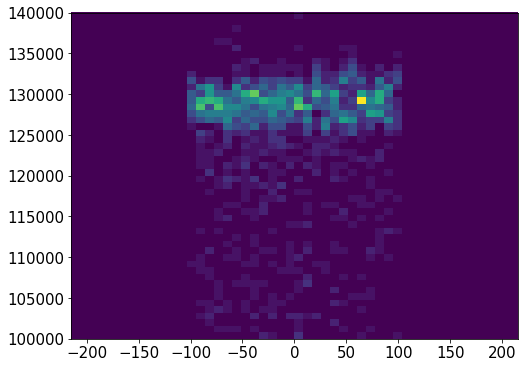

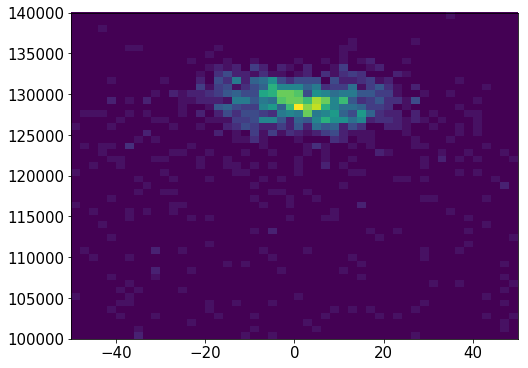

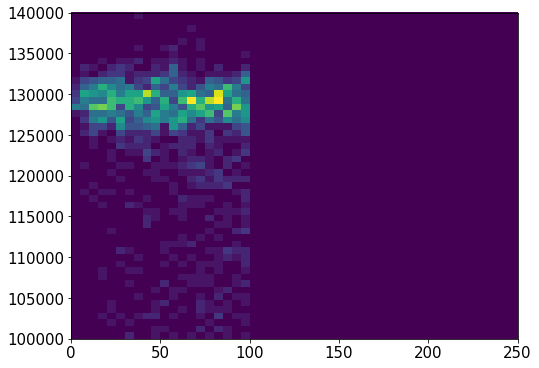

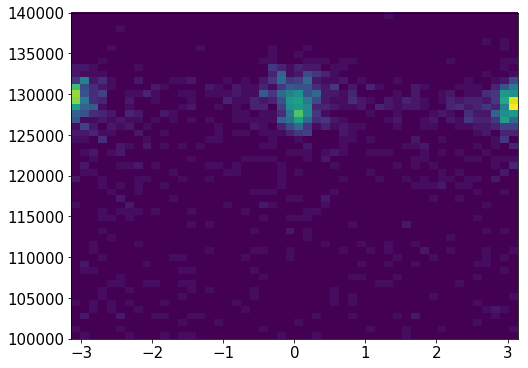

In [22]:
data_ = full[full.nS2 ==1]
selR  = fitf.in_range(data_.R, 0, 100)
data_ = data_[selR]


time         = data_.time.values
time        -= np.min(time)

E = data_.S2e * zcorr(data_.Z) *tcorr(time)* xycorr_c(data_.X.values,data_.Y.values) *xcorr_PP(data_.X.values)*ycorr_PP(data_.Y.values)

hist2d(data_.Z,E,[50,50],[[100,250],[1.0e5, 1.4e5]]);
hist2d(data_.X,E,[50,50],[[-215,215],[1.0e5, 1.4e5]]);
hist2d(data_.Y,E,[50,50],[[-50,50],[1.0e5, 1.4e5]]);
hist2d(data_.R,E,[50,50],[[0,250],[1.0e5, 1.4e5]]);
hist2d(data_.Phi,E,[50,50],[[-pi,pi],[1.0e5, 1.4e5]]);
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

In [23]:
print(len(full[full.nS2 ==1]))

8455


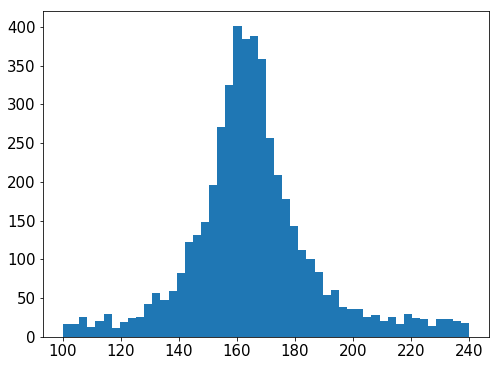

In [24]:
data_ = full[full.nS2 ==1]
selR  = fitf.in_range(data_.R, 0, 180)
data_ = data_[selR]

hist(data_.Z,50,[100,240]);

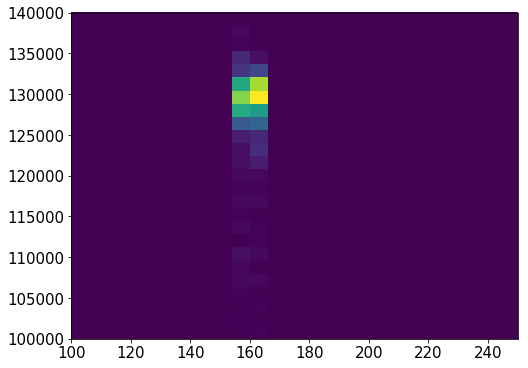

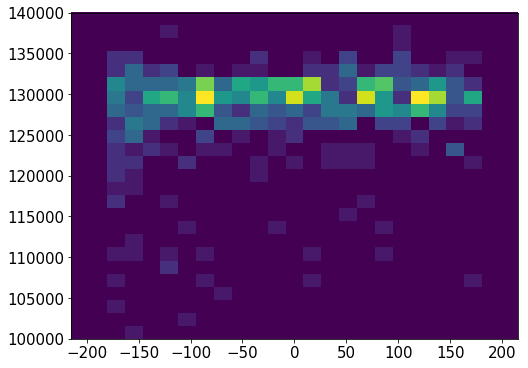

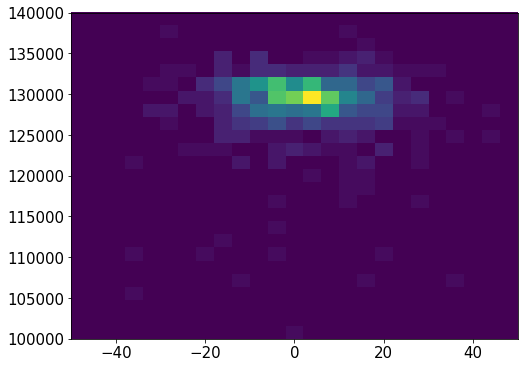

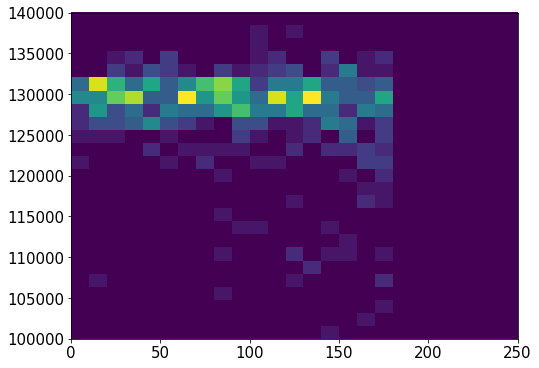

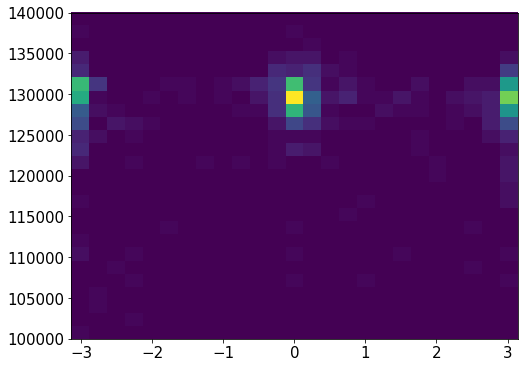

In [25]:
data_ = full[full.nS2 ==1]
selR  = fitf.in_range(data_.R, 0, 180)
selZ  = fitf.in_range(data_.Z,155,165)
data_ = data_[selR&selZ]



time         = data_.time.values
time        -= np.min(time)

E  = data_.S2e * zcorr(data_.Z) *tcorr(time)* xycorr_c(data_.X.values,data_.Y.values) 
E *= xcorr_PP(data_.X.values) * ycorr_PP(data_.Y.values) * zcorr_PP(data_.Z.values)
nbin = 25
hist2d(data_.Z,E,[nbin,nbin],[[100,250],[1.0e5, 1.4e5]]);
hist2d(data_.X,E,[nbin,nbin],[[-215,215],[1.0e5, 1.4e5]]);
hist2d(data_.Y,E,[nbin,nbin],[[-50,50],[1.0e5, 1.4e5]]);
hist2d(data_.R,E,[nbin,nbin],[[0,250],[1.0e5, 1.4e5]]);
hist2d(data_.Phi,E,[nbin,nbin],[[-pi,pi],[1.0e5, 1.4e5]]);
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

/home/brais/Documents/Next/IC/IC-1/invisible_cities/core/fit_functions.py:123: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum(np.ma.masked_invalid((fitx - y)**2/y))


[  3.72769627e+05   1.29882641e+05   1.65735019e+03   2.64741549e+00]
res 0.0300506647394 0.0137016728591


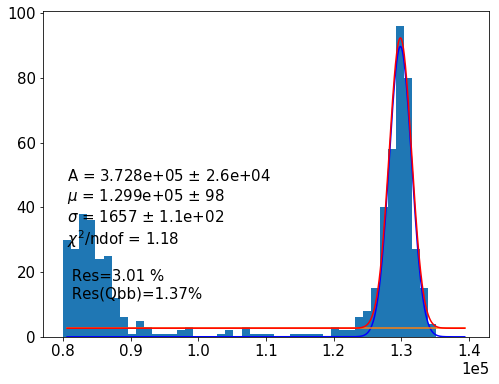

In [29]:
data_ = full[(full.nS2 ==1)&(full.S2w <20)]
selR  = fitf.in_range(data_.R, 0, 100)
selZ  = fitf.in_range(data_.Z,140,190)
data_ = data_[selR&selZ]



time         = data_.time.values
time        -= np.min(time)

E  = data_.S2e * zcorr(data_.Z) *tcorr(time)* xycorr_c(data_.X.values,data_.Y.values) 
E *= xcorr_PP(data_.X.values) * ycorr_PP(data_.Y.values) * zcorr_PP(data_.Z.values)

entries, xbins, _ = hist(E, 50, range=(0.8e5, 1.4e5))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 1.21e5, 1.4e5)


f = fitf.fit(one_gauss, xbins[selbins], entries[selbins],( 9e4 , 1.2e5, 5000, 0.001),
                                                 bounds=([ 1e4 , 1.0e5, 1000,  0],
                                                         [ 10e7, 1.6e5, 10000, 10] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(511/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (511/2458)**0.5*res*100)


xrange = np.linspace(np.min(xbins), np.max(xbins),1000)
plt.text(np.min(xbins), np.mean(entries), text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "b-")
plt.plot(xrange, f.values[-1]*np.ones_like(xrange))
plt.plot(xrange, f.fn(xrange), fitOpt)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

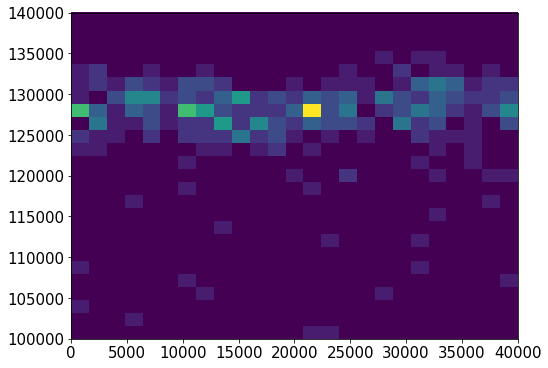

In [90]:
data_ = full[full.nS2 ==1]
selR  = fitf.in_range(data_.R, 0, 180)
selZ  = fitf.in_range(data_.Z,155,165)
data_ = data_[selR&selZ]



time         = data_.time.values
time        -= np.min(time)

E = data_.S2e * zcorr(data_.Z) *tcorr(time)* xycorr_c(data_.X.values,data_.Y.values) *xcorr_PP(data_.X.values)*ycorr_PP(data_.Y.values)
nbin = 25
hist2d(time,E,[nbin,nbin],[[0,0.4e5],[1.0e5, 1.4e5]]);


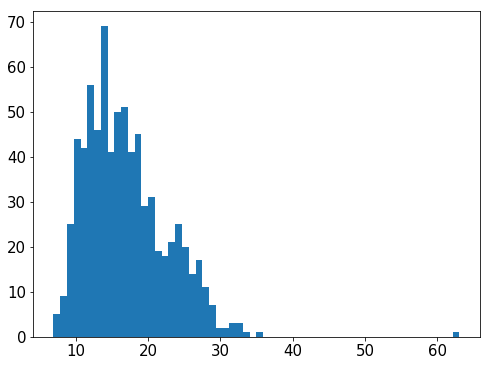

In [91]:
data_ = full[full.nS2 ==1]
selR  = fitf.in_range(data_.R, 0, 180)
selZ  = fitf.in_range(data_.Z,155,165)
data_ = data_[selR&selZ]

hist(data_.S2w,60);

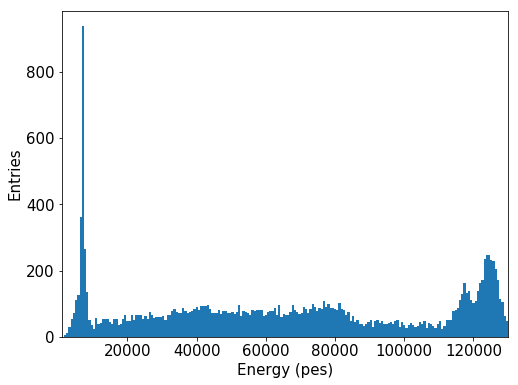

In [53]:
data_ = full[(full.nS2<3)]

time         = data_.time.values
time        -= np.min(time)

E  = data_.S2e * zcorr(data_.Z) *tcorr(time)* xycorr_c(data_.X.values,data_.Y.values) 
#E *= xcorr_PP(data_.X.values) * ycorr_PP(data_.Y.values) * zcorr_PP(data_.Z.values)

entries, xbins, _ = hist(E, 200, range=(1e3, 1.3e5))
plt.xlim(1e3,1.3e5)
plt.xlabel("Energy (pes)")
plt.ylabel("Entries")